# Introduction to Research Module

This tutorial introduces Research functionality of batchflow.

Research class allows easily experimenting with models parameters and entire test and train workflow configurations as well as saving and loading results of experiments in a unified form.

## Roadmap

1. Introduction **<- You are here**
    * Basic example
        * 1 pipeline with fixed parameters
            * creating research
            * running several repetitions of an experiment
            * viewing research results
            * saving and loading research
    * Runnung experiments with different parameters aka grid
        * 1 pipeline with variable parameters
            * creating and viewing grids
            * viewing filtered research results
    * More complex execution strategies
        * 2 pipelines, train & test + function + grid
            * adding test pipeline
            * defining pipeline execution frequency
            * adding functions

1. Advanced topics
    * Reducing extra dataset loads
        * 1 pipeline with root and branch + grid
    * Performance
        * execution tasks managing
    * Cross-validation

1. Combining it all together
    * Super complex Research

## Basic example

We start with some useful imports and constant definitions

In [1]:
import sys
sys.path.append('../../..')

import matplotlib
%matplotlib inline

from batchflow import Pipeline, B, C, V
from batchflow.opensets import MNIST
from batchflow.models.tf import VGG7, VGG16
from batchflow.research import Research, Option

In [2]:
BATCH_SIZE=64
ITERATIONS=1000

We define a very simple pipeline that loads some MNIST data, and trains a VGG7 model on it. It also saves the loss on each iteration in a pipeline variable. Let's call it an experiment

We call a lazy version of pipeline's `run` method to define batch size to use. We pass `n_epochs=None`, because the duration of our experiment will be controlled by Research

In [3]:
mnist = MNIST()
train_root = mnist.train.p.run(BATCH_SIZE, shuffle=True, n_epochs=None, lazy=True)

model_config={
    'inputs': dict(images={'shape': (28, 28, 1)},
                   labels={'classes': 10, 'transform': 'ohe', 'name': 'targets'}),
    'initial_block/inputs': 'images',
}

train_template = (Pipeline()
            .init_variable('loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', fetches='loss',
                         feed_dict={'images': B('images'),
                                    'labels': B('labels')},
                         save_to=V('loss', mode='w'))
)

train_ppl = train_root + train_template

The simpliest thing we can do with Research is running this experiment several times to see how loss'es dynamics changes from run to run.

To do this we define a Research object and add the pipeline to it. We call `add_pipeline` method and pass the `train_ppl` as the first parameter. The `variables` parameter gets a string or a list of strings that indicate which pipeline variables will be monitored by Research and written to research results on each iteration. We also provide `name` that will be written to results to indicate from where actually these results come.

`logging=True` adds additional logging of the pipeline execution to log file

In [4]:
research = (Research()
            .add_pipeline(train_ppl, variables='loss', name='train_ppl', logging=True))

Now we run this Research.

We call a Research object's `run` method and we pass following parameters:
* `n_iters` - how many iterations will the experiment consist of. Each iteration here consists of processing a single batch
* `n_reps` - how many times we run our experiment
* `bar` - to provide a tqdm progress bar

In [5]:
research.run(n_reps=4, n_iters=ITERATIONS, name='vgg7_research', bar=True)

Research vgg7_research is starting...
Distributor has 4 jobs with 1000 iterations. Totally: 4000


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [03:38<00:00, 18.34it/s]


Each research is assigned with a `name` argument provided to `run`.
Results of the research and its log are saved in a folder with the same name in the working directory. 

In [6]:
import os
for name in os.listdir():
    print("{}\t{}".format('Dir' if os.path.isdir(name) else 'File', name))

Dir	.ipynb_checkpoints
File	1_Research_Introduction.ipynb
File	2_Research_pipelines.ipynb
File	3_Cross_validation.ipynb
Dir	vgg7_research


To see the experiments' results we call `load_result` method which returns a Pandas Dataframe. We can see that it has 4 collumns which contain 
* repetition - The number of experiment run
* iteration - the number of iteration
* name - the source of the variable
* loss - this is the variable name that we provided to `add_pipeline`

In [7]:
results = research.load_results()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 999
Data columns (total 4 columns):
repetition    4000 non-null int64
name          4000 non-null object
loss          4000 non-null float64
iteration     4000 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 156.2+ KB


In [8]:
results.sample(10)

,repetition,name,loss,iteration
560,3,train_ppl,0.090442,560
898,2,train_ppl,0.086030,898
597,3,train_ppl,0.037583,597
357,2,train_ppl,0.080738,357
566,3,train_ppl,0.053853,566
280,1,train_ppl,0.148327,280
92,0,train_ppl,0.259657,92
53,3,train_ppl,0.810045,53
900,2,train_ppl,0.091405,900
917,2,train_ppl,0.041945,917


We can now draw a nice plot showing our loss dynamics on each experiment repetition

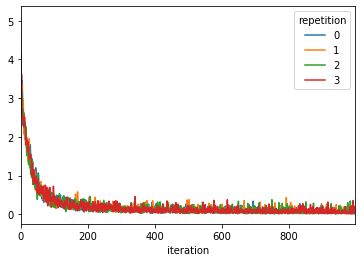

In [9]:
results.pivot(index='iteration', columns='repetition', values='loss').plot()

## Introducing grids

We have learned to run multiple repetitions of a single experiment with Research. 

We can also run several experiments with different parameters in one research. Suppose we want to compare the performance of VGG7 and VGG16 models with different layouts ('convolution-normalization-activation' vs 'convolution-activation-normalization') without bias and we would also like to check VGG7 preformance with bias and default 'cna' layout.

To do so we define a grid of parameters as follows. 
We define an Option that consists of the parameter to vary and a list of values that we want to try in our research. Each parameter value defines a node in a parameter grid. We can add grids to unite the nodes and multiply grids to get Cartesian product.

`grid.gen_configs()` returns a generator that yields one node (that is, a single experiment specification) at a time. Printing a list of all nodes shows us all experiment modifications in a dict-like mode.

In [10]:
grid = (Option('layout', ['cna', 'can']) * Option('model', [VGG7, VGG16]) * Option('bias', [False])
        +  Option('layout', ['cna']) * Option('bias', [True]) * Option('model', [VGG7]))
list(grid.gen_configs())

[ConfigAlias({'layout': 'cna', 'model': 'VGG7', 'bias': 'False'}),
 ConfigAlias({'layout': 'cna', 'model': 'VGG16', 'bias': 'False'}),
 ConfigAlias({'layout': 'can', 'model': 'VGG7', 'bias': 'False'}),
 ConfigAlias({'layout': 'can', 'model': 'VGG16', 'bias': 'False'}),
 ConfigAlias({'layout': 'cna', 'bias': 'True', 'model': 'VGG7'})]

We should now update `model_config` so that it could read the values from the grid.

We pass named expressions as parameters values with names from our parameter grid. 
We define layout and bias in the model config and we pass model type as a named expression to `init_model` method of the pipeline (config option named expression `C()` should be used)

In [11]:
model_config.update({
    'body/block/layout': C('layout'),
    'common/conv/use_bias': C('bias'),
})


# For reference: previous train_template definition 
#     train_template = (Pipeline()
#                 .init_variable('loss', init_on_each_run=list)
#                 .init_model('dynamic', VGG7, 'conv', config=model_config) # Note model class defined explicitly
#                 .to_array()
#                 .train_model('conv', fetches='loss',
#                              feed_dict={'images': B('images'),
#                                         'labels': B('labels')},
#                              save_to=V('loss', mode='w'))
#     )

train_template = (Pipeline()
            .init_variable('loss', init_on_each_run=list)
            .init_model('dynamic', C('model'), 'conv', config=model_config) # Model class defined via named expression
            .to_array()
            .train_model('conv', fetches='loss',
                         feed_dict={'images': B('images'),
                                    'labels': B('labels')},
                         save_to=V('loss', mode='w'))
)

train_ppl = train_root + train_template

We define a new research as before but also add the grid of parameters with `add_grid` method. After that we run the research, and it takes much longer because we are now running 5 different experiments 2 times each. 

In [12]:
research = (Research()
            .add_pipeline(train_ppl, variables='loss', name='train')
            .add_grid(grid))

research.run(n_reps=2, n_iters=ITERATIONS, name='vgg_layout_bias_research', bar=True)


Research vgg_layout_bias_research is starting...
Distributor has 10 jobs with 1000 iterations. Totally: 10000


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:40<00:00, 12.19it/s]


Research results now contain new columns *layout*, *bias* and *model* with corresponding parameter values.

In [13]:
results = research.load_results()
results.head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,4.109422,VGG7,train,0
1,False,1,cna,3.650691,VGG7,train,0
2,False,2,cna,3.676604,VGG7,train,0
3,False,3,cna,2.962270,VGG7,train,0
4,False,4,cna,2.822446,VGG7,train,0


#### Controlling *load_results* output

To combine different config options in a single-column string representation we can pass `use_alias=True` to `load_results` method.

In [14]:
results = research.load_results(use_alias=True)
results.head()

,repetition,name,loss,iteration,config
0,0,train,4.109422,0,bias_False-layout_cna-model_VGG7
1,0,train,3.650691,1,bias_False-layout_cna-model_VGG7
2,0,train,3.676604,2,bias_False-layout_cna-model_VGG7
3,0,train,2.962270,3,bias_False-layout_cna-model_VGG7
4,0,train,2.822446,4,bias_False-layout_cna-model_VGG7


This is very useful when comparing separate experiments  

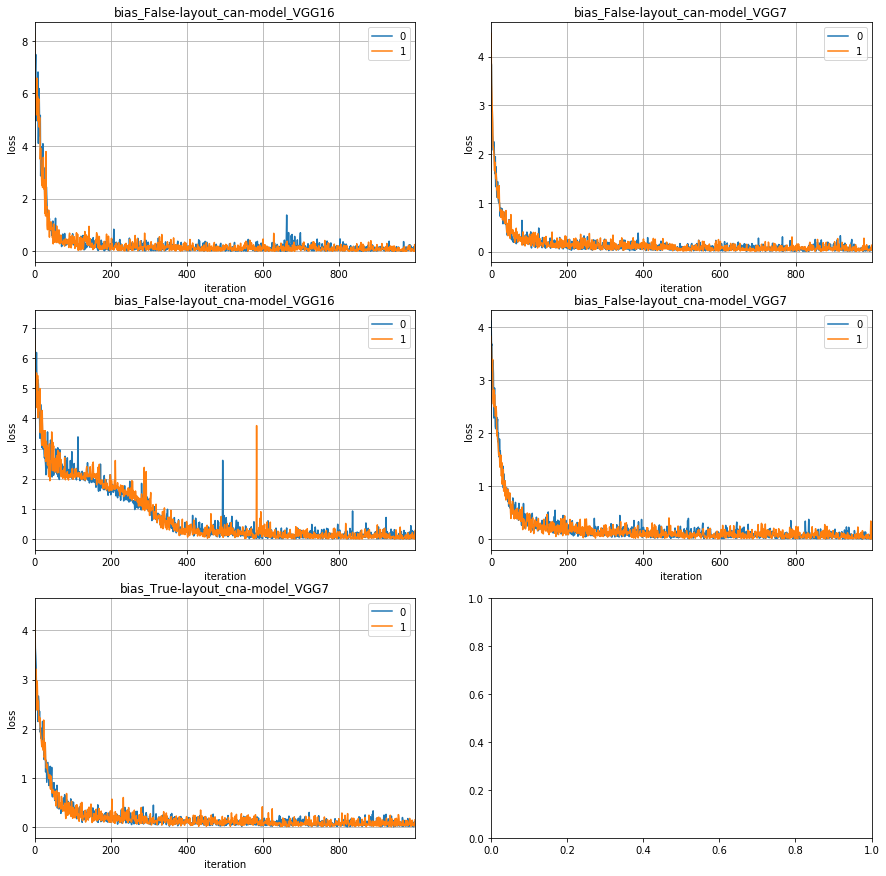

In [15]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, (config, df) in enumerate(results.groupby('config')):
    x, y = i//2, i%2
    df.pivot(index='iteration', columns='repetition', values='loss').plot(ax=ax[x, y])
    ax[x, y].set_title(config)
    ax[x, y].set_xlabel('iteration')
    ax[x, y].set_ylabel('loss')
    ax[x, y].grid(True)
    ax[x, y].legend()

We can filter the results to use certain parameter values.

In [16]:
research.load_results(aliases={'model': 'VGG7'}).head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,4.109422,VGG7,train,0
1,False,1,cna,3.650691,VGG7,train,0
2,False,2,cna,3.676604,VGG7,train,0
3,False,3,cna,2.962270,VGG7,train,0
4,False,4,cna,2.822446,VGG7,train,0


The code below does effectively the same but when passing `config` we define actual parameter values (like model class), not their string representations

In [17]:
research.load_results(configs={'model': VGG7}).head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,4.109422,VGG7,train,0
1,False,1,cna,3.650691,VGG7,train,0
2,False,2,cna,3.676604,VGG7,train,0
3,False,3,cna,2.962270,VGG7,train,0
4,False,4,cna,2.822446,VGG7,train,0


We can also get results corresponding to certain repetitions of experiments or certain iterations.

Here we have only one output variable - *loss* - but if we had many we could also load only some of them using `variables` parameter

In [18]:
research.load_results(repetitions=1, iterations=[0,9], variables=['loss']).head()

,bias,iteration,layout,loss,model,name,repetition
0,False,0,cna,3.821848,VGG7,train,1
1,False,9,cna,2.726494,VGG7,train,1
0,False,0,cna,6.674659,VGG16,train,1
1,False,9,cna,4.030333,VGG16,train,1
0,False,0,can,4.478671,VGG7,train,1


### Loading saved researches 

<font color=red size=5>**BROKEN**</font>

As mentioned above, after each run of a research a folder with log information and results is created

In [19]:
for name in os.listdir():
    print("{}\t{}".format('Dir' if os.path.isdir(name) else 'File', name))

Dir	.ipynb_checkpoints
File	1_Research_Introduction.ipynb
File	2_Research_pipelines.ipynb
File	3_Cross_validation.ipynb
Dir	vgg7_research
Dir	vgg_layout_bias_research


We can use `Research.load` class method to load a previousely run research by its name

In [20]:
#loaded_research = Research.load('vgg_layout_bias_research')

We can check its parameters...

In [21]:
#loaded_research.describe()

... and run it one more time

In [22]:
#loaded_research.run(n_reps=4, n_iters=ITERATIONS, name='vgg7_research_1_load', bar=True)

Note that `n_reps=4, name='vgg7_research_1_load'` from `run` arguments are ignored and the values from the loaded research are used

In [23]:
#loaded_research.load_results().sample(10)

## More complex execution strategies

Usually we would like to run more than a single train pipeline.

Let's define a test pipeline to monitor a model's loss on test set while learning. 

We start with defining a train pipeline as before

In [24]:
grid = Option('layout', ['cna', 'can'])

model_config={
    'inputs': dict(images={'shape': (28, 28, 1)},
                   labels={'classes': 10, 'transform': 'ohe', 'name': 'targets'}),
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
}

train_template = (Pipeline()
            .init_variable('train_loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', fetches='loss',
                         feed_dict={'images': B('images'),
                                    'labels': B('labels')},
                         save_to=V('train_loss', mode='w'))
)

train_ppl = train_root + train_template

We want the test pipeline to be run on the whole test set from time to time during training. 

In order to get this, we specify lazy-run in test pipeline with `n_epochs=1` and we pass `run=True` to research's `add_pipeline`. These 2 parameter values tell Research to run the pipeline on the whole test set for 1 epoch, instead of running it batch-wise (which is how the test pipeline is run). We also pass `execute='%100'` parameter to `add_pipeline` to tell Research that this pipeline should be executed only on each 100-th iteration.

To let the test pipeline to use the model trained by train pipeline we pass this model via `C('import_from')` named expression. We call `import_model` of test pipeline and pass `import_from='train_ppl'` parameter to `add_pipeline`, where `'train_ppl'` is the name of our train pipeline.

In [25]:
test_root = mnist.test.p.run(BATCH_SIZE, shuffle=True, n_epochs=1, lazy=True) #Note  n_epochs=1
test_template = (Pipeline()
                 .init_variable('test_loss')
                 .import_model('conv', C('import_from'))
                 .to_array()
                 .predict_model('conv', 
                               fetches='loss',
                               feed_dict={'images': B('images'),
                                          'labels': B('labels')},
                               save_to=V('test_loss', mode='w')))

test_ppl = test_root + test_template

In [26]:
TEST_EXECUTE_FREQ = '%100'

In [27]:
research = (Research()
            .add_pipeline(train_ppl, variables='train_loss', name='train_ppl')
            .add_pipeline(test_ppl, variables='test_loss', name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl') # Note run=True
            .add_grid(grid))

research.run(n_iters=ITERATIONS, name='train_test_research', bar=True)


Research train_test_research is starting...
Distributor has 2 jobs with 1000 iterations. Totally: 2000


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:35<00:00, 12.83it/s]


Now our research results contain entries for test_ppl

In [28]:
results = research.load_results()
results.sample(10)

,repetition,name,train_loss,test_loss,iteration,layout
765,0,train_ppl,0.056118,NaN,765,cna
144,0,train_ppl,0.254249,NaN,144,can
920,0,train_ppl,0.030825,NaN,920,can
129,0,train_ppl,0.185633,NaN,129,cna
319,0,train_ppl,0.048088,NaN,319,can
433,0,train_ppl,0.047814,NaN,433,can
201,0,train_ppl,0.276337,NaN,201,can
858,0,train_ppl,0.033429,NaN,858,cna
582,0,train_ppl,0.022289,NaN,582,cna
895,0,train_ppl,0.099875,NaN,895,cna


## Functions

In order to perform some computations while running pipelines, for example to acquire values that are not produced by the model explicitely, one can use functions.

We will now add a function to calculate model's accuracy on test set

We redefine test pipeline removing `'test_loss'` and adding variables to store predictions and metrics computed for these predictions with `gather_metrics`

In [29]:
test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array()
                 .predict_model('conv', 
                               fetches='predictions',
                               feed_dict={'images': B('images'),
                                          'labels': B('labels')},
                               save_to=V('predictions'))
                .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=-1, save_to=V('metrics')))

test_ppl = test_root + test_template

We also define a function to be executed during experiment's iterations. Such functions take 2 required parameters: `iteration` and `experiment` which are fed to it by Research and optional keyword parameters which should be provided externally.

In [30]:
def get_accuracy(iteration, experiment, pipeline):
    pipeline = experiment[pipeline].pipeline
    metrics = pipeline.get_variable('metrics')
    return metrics.evaluate('accuracy')

We define a new reseach. Note that we now don't ask the test pipeline to write any variables to results explicitely (we don't pass `variables` parameter to corresponding `add_pipeline`.

To add a function we call `add_function` method, providing it with a function object and`returns` parameters that specifies what should be written to research results.  We also pass keyword parameter `pipeline='test_ppl'` that will be substituted to `get_accuracy`.

In [31]:
research = (Research()
            .add_pipeline(train_ppl, variables='train_loss', name='train_ppl')
            .add_pipeline(test_ppl, name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl')
            .add_function(get_accuracy, returns='accuracy', name='test_accuracy_fn', 
                          execute=TEST_EXECUTE_FREQ, pipeline='test_ppl')
            .add_grid(grid))

research.run(n_reps=1, n_iters=ITERATIONS, name='fun_research', bar=True)

Research fun_research is starting...
Distributor has 2 jobs with 1000 iterations. Totally: 2000


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:40<00:00, 12.43it/s]


Research results now contain accuracy from `'test_accuracy_fn'`

We can load results that come from a certain source by passing `names` parameter to `load_results`

In [33]:
research.load_results(names='test_accuracy_fn').sample(5)

,repetition,name,train_loss,accuracy,iteration,layout
4,0,test_accuracy_fn,NaN,1.0000,499,cna
6,0,test_accuracy_fn,NaN,1.0000,699,can
3,0,test_accuracy_fn,NaN,0.9375,399,cna
8,0,test_accuracy_fn,NaN,1.0000,899,cna
0,0,test_accuracy_fn,NaN,1.0000,99,cna


Actually collecting metrics is a very common case so there is a special method `get_metrics`. We pass pipeline name to collect metrics from (`pipeline`), the name of the named expression which stores collected metrics (`metrics_var`) and what to calculate(`metrics_name`). 

In [34]:
research = (Research()
            .add_pipeline(train_ppl, variables='train_loss', name='train_ppl')
            .add_pipeline(test_ppl, name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl')
            .get_metrics(pipeline='test_ppl', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', execute=TEST_EXECUTE_FREQ)
            .add_grid(grid))

research.run(n_reps=1, n_iters=ITERATIONS, name='get_metrics_research', bar=True)

Research get_metrics_research is starting...
Distributor has 2 jobs with 1000 iterations. Totally: 2000


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:40<00:00, 12.50it/s]


`get_metrics` implicitely adds a function with a name *\[pipeline_name\]_metrics* 

In [39]:
research.load_results(names='test_ppl_metrics').sample(10)

,repetition,name,train_loss,accuracy,iteration,layout
2,0,test_ppl_metrics,NaN,0.9375,299,cna
9,0,test_ppl_metrics,NaN,1.0000,999,cna
8,0,test_ppl_metrics,NaN,1.0000,899,can
9,0,test_ppl_metrics,NaN,1.0000,999,can
0,0,test_ppl_metrics,NaN,1.0000,99,can
5,0,test_ppl_metrics,NaN,1.0000,599,cna
1,0,test_ppl_metrics,NaN,1.0000,199,cna
6,0,test_ppl_metrics,NaN,0.9375,699,can
7,0,test_ppl_metrics,NaN,1.0000,799,cna
3,0,test_ppl_metrics,NaN,1.0000,399,cna
